In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words 
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
#build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xva, Yva = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons ini the hidden layer of the mlp

g = torch.Generator().manual_seed(2147483647) # for reproducibility 
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.rand((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.02
W2 = torch.rand((n_hidden, vocab_size), generator=g) * 0.02
b2 = torch.randn(vocab_size, generator=g) * 0 

# Batch norm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total 
for p in parameters:
    p.requires_grad = True

12297


In [66]:
hpreact.shape

torch.Size([182625, 200])

In [67]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [68]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    #forward pass
    emb = C[Xb] # embedd the charaters into vectors
    embcat = emb.view(emb.shape[0], -1) # concat the vectors
    
    # Linear layer 
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    
    # BatchNorm layer 
    # ------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    
    with torch.no_grad():
        bnmean_running = bnmean_running * 0.999 + bnmeani * 0.001
        bnstd_running = bnstd_running * 0.999 + bnstdi * 0.001
    
    # ------------------------------------------------------------
    # Non-linearity 
    h = torch.tanh(hpreact) # hidden layer activation
    logits = h @ W2 + b2 # output layer pre-activation
    loss = F.cross_entropy(logits, Yb) # compute loss
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay 
    for p in parameters: 
        p.data += -lr * p.grad
        
    # track stats 
    if i % 10000 == 0: #  print every once in a while 
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.item())

      0/ 200000: 3.2999
  10000/ 200000: 1.9092
  20000/ 200000: 1.8588
  30000/ 200000: 2.2118
  40000/ 200000: 2.2041
  50000/ 200000: 2.3526
  60000/ 200000: 1.9673
  70000/ 200000: 1.8962
  80000/ 200000: 2.3055
  90000/ 200000: 2.1659
 100000/ 200000: 2.0204
 110000/ 200000: 2.2702
 120000/ 200000: 1.8128
 130000/ 200000: 2.1509
 140000/ 200000: 2.0578
 150000/ 200000: 2.2298
 160000/ 200000: 2.2813
 170000/ 200000: 1.5957
 180000/ 200000: 1.9704
 190000/ 200000: 2.2393


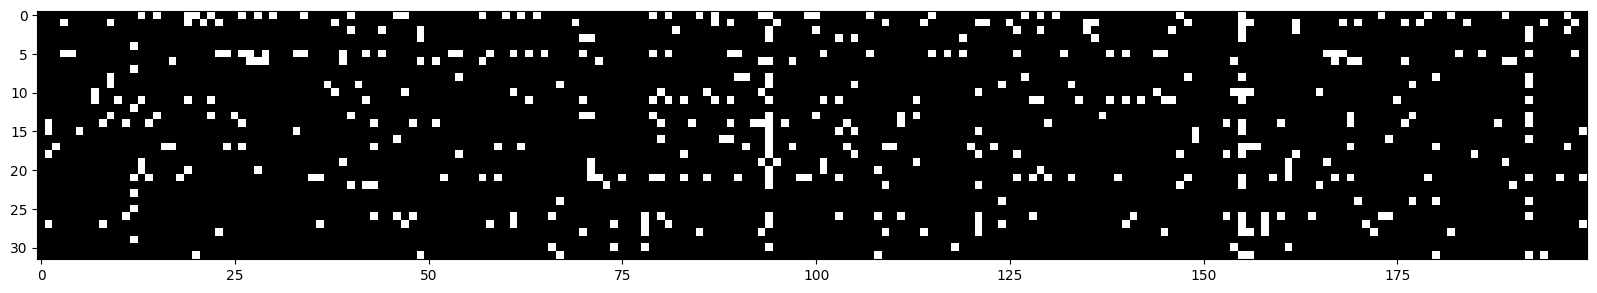

In [70]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

(array([508., 246., 164., 146., 116., 114., 128.,  94.,  99.,  93.,  92.,
        108., 113.,  69., 106.,  77.,  67.,  95., 121., 100.,  85., 100.,
        106., 172., 169., 156., 121.,  95., 104., 110., 122.,  99., 104.,
         69.,  91., 101.,  54.,  73.,  83.,  82.,  93.,  88.,  98., 103.,
        112., 143., 116., 162., 219., 514.]),
 array([-9.99984026e-01, -9.59984789e-01, -9.19985552e-01, -8.79986315e-01,
        -8.39987078e-01, -7.99987841e-01, -7.59988604e-01, -7.19989367e-01,
        -6.79990129e-01, -6.39990892e-01, -5.99991655e-01, -5.59992418e-01,
        -5.19993181e-01, -4.79993944e-01, -4.39994707e-01, -3.99995470e-01,
        -3.59996233e-01, -3.19996996e-01, -2.79997759e-01, -2.39998522e-01,
        -1.99999285e-01, -1.60000048e-01, -1.20000811e-01, -8.00015736e-02,
        -4.00023365e-02, -3.09944153e-06,  3.99961376e-02,  7.99953747e-02,
         1.19994612e-01,  1.59993849e-01,  1.99993086e-01,  2.39992323e-01,
         2.79991560e-01,  3.19990797e-01,  3.59990

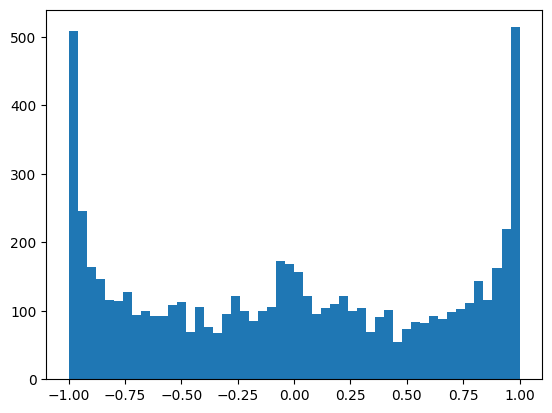

In [71]:
plt.hist(h.view(-1,).tolist(), 50)

(array([  2.,   1.,   2.,   2.,   2.,   4.,   3.,  11.,  16.,  13.,  21.,
         42.,  47.,  65.,  70.,  92., 121., 149., 171., 218., 229., 318.,
        360., 425., 562., 785., 544., 375., 294., 277., 238., 181., 142.,
        135., 125.,  83.,  63.,  62.,  42.,  32.,  15.,  13.,  15.,  15.,
          4.,   6.,   4.,   2.,   1.,   1.]),
 array([-5.86799145, -5.63653749, -5.40508354, -5.17362959, -4.94217564,
        -4.71072168, -4.47926773, -4.24781378, -4.01635983, -3.78490587,
        -3.55345192, -3.32199797, -3.09054401, -2.85909006, -2.62763611,
        -2.39618216, -2.1647282 , -1.93327425, -1.7018203 , -1.47036634,
        -1.23891239, -1.00745844, -0.77600449, -0.54455053, -0.31309658,
        -0.08164263,  0.14981133,  0.38126528,  0.61271923,  0.84417318,
         1.07562714,  1.30708109,  1.53853504,  1.76998899,  2.00144295,
         2.2328969 ,  2.46435085,  2.69580481,  2.92725876,  3.15871271,
         3.39016666,  3.62162062,  3.85307457,  4.08452852,  4.31598248,
 

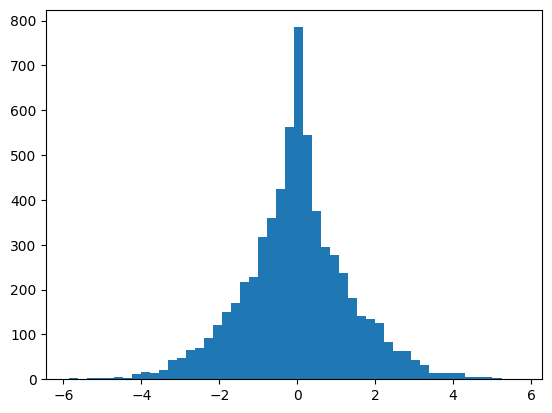

In [72]:
plt.hist(hpreact.view(-1).tolist(),50)

In [73]:
logits[0]

tensor([ 3.8071,  4.9012,  2.5235, -2.7200,  0.6772,  1.8827, -0.3246, -2.2217,
        -0.2201,  3.4181, -1.8232, -1.8781,  0.7966,  2.7443, -0.4268,  1.5515,
         0.8932, -2.4625,  1.4213,  0.4718,  0.3338,  2.0394, -2.6640,  1.5786,
        -4.0125,  1.6959,  1.6491], grad_fn=<SelectBackward0>)

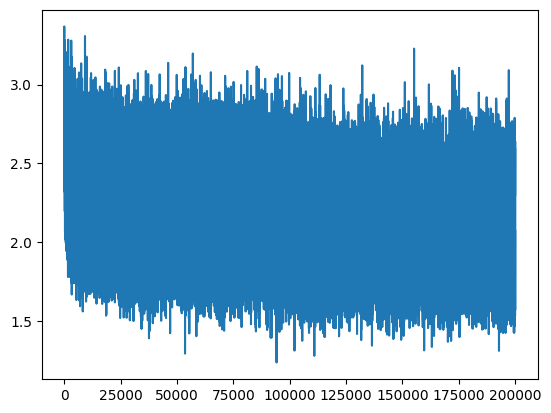

In [74]:
plt.plot(lossi)

In [75]:
# calibrate the batch norm at the end of training 

with torch.no_grad():
    # pass the training set through 
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [78]:
bnstd

tensor([[1.7723, 2.3911, 1.9101, 1.8743, 1.7488, 1.7565, 2.0193, 2.1019, 1.9965,
         1.9487, 1.6688, 1.7449, 2.5841, 2.0658, 1.8814, 1.9104, 1.6248, 1.8023,
         2.0151, 2.1769, 1.9349, 1.9005, 1.8609, 2.1847, 2.1785, 1.9879, 2.0767,
         1.8563, 2.2910, 2.0781, 1.7896, 1.5043, 1.1415, 2.0666, 2.1582, 1.8131,
         1.8935, 1.5891, 2.2767, 2.1206, 2.0316, 2.2416, 2.0333, 1.9730, 2.0672,
         1.5484, 1.9875, 2.2856, 1.7673, 2.1335, 1.9725, 2.0840, 1.7568, 1.7215,
         2.0275, 1.2467, 1.2190, 1.9385, 2.1325, 2.2665, 2.1759, 2.4586, 2.4577,
         2.1361, 2.3163, 1.9629, 1.9248, 2.1066, 1.6180, 1.8087, 2.3850, 2.2126,
         2.3789, 1.7880, 2.0740, 1.9528, 1.0493, 1.7759, 2.2976, 2.0728, 2.3646,
         1.9951, 2.1166, 1.8140, 1.7663, 1.8297, 1.9374, 1.9775, 2.3142, 1.8491,
         2.1276, 2.0255, 1.8751, 1.7217, 2.5346, 2.2913, 1.9049, 2.0204, 1.8464,
         1.8788, 2.1125, 2.2243, 1.7890, 1.9897, 1.9622, 2.1808, 1.7666, 1.6277,
         2.1021, 1.9604, 1.8

In [79]:
bnstd_running

tensor([[1.7619, 2.3635, 1.8914, 1.8556, 1.7302, 1.7338, 2.0130, 2.0892, 1.9774,
         1.9320, 1.6465, 1.7203, 2.5758, 2.0444, 1.8585, 1.8863, 1.6071, 1.7931,
         1.9945, 2.1376, 1.9194, 1.8823, 1.8300, 2.1675, 2.1475, 1.9752, 2.0515,
         1.8416, 2.2571, 2.0602, 1.7671, 1.4857, 1.1301, 2.0480, 2.1424, 1.8002,
         1.8847, 1.5591, 2.2507, 2.1039, 2.0134, 2.2290, 2.0063, 1.9411, 2.0400,
         1.5273, 1.9649, 2.2561, 1.7351, 2.1085, 1.9353, 2.0504, 1.7337, 1.7032,
         2.0060, 1.2263, 1.1951, 1.9173, 2.1126, 2.2341, 2.1579, 2.4441, 2.4378,
         2.1080, 2.3000, 1.9417, 1.8995, 2.0817, 1.6128, 1.7887, 2.3492, 2.1906,
         2.3466, 1.7738, 2.0375, 1.9289, 1.0404, 1.7538, 2.2786, 2.0321, 2.3485,
         1.9595, 2.0879, 1.7956, 1.7453, 1.8059, 1.9230, 1.9621, 2.2949, 1.8157,
         2.0894, 2.0107, 1.8501, 1.7005, 2.5203, 2.2758, 1.8834, 1.9844, 1.8158,
         1.8611, 2.0836, 2.1875, 1.7629, 1.9663, 1.9431, 2.1561, 1.7483, 1.6033,
         2.0790, 1.9432, 1.8

In [80]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xva, Yva),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) #  concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1 # (N, n_hidden)
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / (hpreact.std(0, keepdim=True) + bnbias)
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # (N, vocab_size)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.062875986099243
val 2.1071994304656982


In [11]:
# sample from the model 

g = torch.Generator().manual_seed(2147483647)

for _ in range(20): 
    
    out = []
    context = [0] * block_size
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1) 
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from distribution 
        ix = torch.multinomial(probs[0], num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break 
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

dex.
mariah.
makilah.
tyreell.
imitta.
nella.
kama.
darreliyah.
jaxson.
mari.
moriella.
kinzie.
darek.
emma.
sadel.
akavion.
raslyn.
huniel.
viah.
ash.
